In [14]:
# import standard libraries
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [15]:
# import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [16]:
# Add OOM errrors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

MOVE DATASET FROM LFW TO DATA FOLDER

In [17]:
# Set up paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [18]:
# Make directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [19]:
# for directory in os.listdir('lfw'): # loop directory
#   for file in os.listdir(os.path.join('lfw', directory)): # loop files
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

COLLECT POSITIVE AND ANCHOR CLASSES

In [20]:
import uuid

In [21]:
# uuid?? -> "??" Used for library information tracking 

In [22]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame  = cap.read()
  frame = frame[120: 120 + 250, 200:200 + 250, :]
  cv2.imshow('Image Collection', frame)

  # Collect Anchor Images
  if cv2.waitKey(1) & 0xFF == ord('a'):
    # Create unique file path
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    # Write out anchor image
    cv2.imwrite(imgname, frame)

  # Collect Positive Images
  if cv2.waitKey(1) & 0xFF == ord('p'):
    # Create unique file path
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    # Write out anchor image
    cv2.imwrite(imgname, frame)

  # Breaking gracefully
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

LOAD AND PREPROCESS IMAGES

In [24]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

In [34]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\9f580497-9120-11ef-babf-fb89cd63b556.jpg'


PREPROCESSING

In [41]:
def preprocess(file_path):
  # Read in image from file path
  byte_img = tf.io.read_file(file_path)
  # Load in the image
  img = tf.io.decode_jpeg(byte_img)

  # Preprocessing steps - resize image size from 250 x 250 to 100 x 100
  img = tf.image.resize(img, (100, 100))

  # Scale image from 0 to 1
  img = img / 255.0
  return img

In [43]:
img = preprocess('data\\anchor\\9f580497-9120-11ef-babf-fb89cd63b556.jpg')
img.numpy().min()
img.numpy().max()

0.0

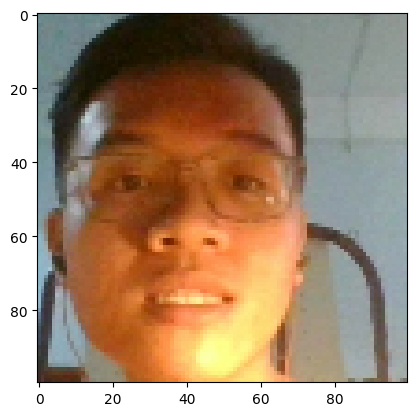

In [44]:
plt.imshow(img)

CREATE LABELED DATASET

In [46]:
# (anchor, positive) => [1,1,1,1,1]
# (anchor, negative) => [0,0,0,0,0]

In [50]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [47]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [55]:
samples = data.as_numpy_iterator()

In [72]:
example = samples.next()

BUILD TRAIN AND TEST PARTITION

In [69]:
def preprocess_twin(input_img, validation_img, label):
  return (preprocess(input_img), preprocess(validation_img), label)

In [74]:
# * is used for unpacking value inside example
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.45318627, 0.5512255 , 0.5708333 ],
         [0.44705883, 0.5568628 , 0.5715686 ],
         [0.4343137 , 0.55      , 0.5588235 ],
         ...,
         [0.5625    , 0.6213235 , 0.59387255],
         [0.5708333 , 0.6237745 , 0.59632355],
         [0.57058823, 0.6137255 , 0.5901961 ]],
 
        [[0.45906863, 0.5568628 , 0.58504903],
         [0.45441177, 0.55539215, 0.5754902 ],
         [0.44485295, 0.55465686, 0.5681372 ],
         ...,
         [0.5622549 , 0.6166667 , 0.5921569 ],
         [0.5769608 , 0.6262255 , 0.6017157 ],
         [0.5745098 , 0.61764705, 0.59607846]],
 
        [[0.4502451 , 0.5531863 , 0.5894608 ],
         [0.43946078, 0.5512255 , 0.5757353 ],
         [0.4404412 , 0.5531863 , 0.57034314],
         ...,
         [0.59142154, 0.6377451 , 0.6220588 ],
         [0.5889706 , 0.63235295, 0.6166667 ],
         [0.59044117, 0.6335784 , 0.61789215]],
 
        ...,
 
        [[0.22892156, 0.19166666

In [79]:
# res[0] -> anchor
# res[1] -> positive
# res[2] -> label

1.0

In [81]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [97]:
# Mixed up the data to prevent overfitting
sample = data.as_numpy_iterator()
sample.next()[2]

1.0

In [ ]:
# Training partition
# Take 70% of the data for training
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
# Prevent bottlenecking
train_data = train_data.prefetch(8)